##  Objective
To study the effect of immune infiltration in endocrine treated breast cancer patients. The data is from 36 patients who have been given Anastrazole and saples have been taken from before and after treatment. The dataset contains 15 non-responders and 24 responders.

### Import packages

In [117]:
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
from scipy import stats

### Import data
The immune signature was defined by a manual feature selection of the most co-expressed genes (ImSig), identified from the network graph.

In [11]:
# Set Working directory
WD = '//ris-fas1a.roslin.ed.ac.uk/v1anirma/Win7/Desktop/Anastrazole'
os.chdir(WD)
# Import data
exp = pd.read_csv('pre_collapse.txt', delimiter='\t', index_col=0)
sig = pd.read_csv('feature selected genes.txt', delimiter='\t', index_col=0)
response = pd.read_csv('response.txt', delimiter='\t', index_col=0)

### Reduce multiple transcripts into one gene

In [12]:
grouped = exp.groupby(exp.index).max()
grouped = grouped.apply(lambda x: np.power(x,2), axis=1)
# Write out the collapsed DataFrame if necessary
# grouped.to_csv('Post Collapse.txt', sep= "\t")

### Calculate the average expression of signature genes
The objective is to test if there is a change in the number of immune cells between the responders and non-responders. 

In [21]:
# Subset exp for sig genes
exp_sig = grouped.merge(sig, how='inner',  left_index=True, right_index=True).sort_values(['ImSig'])
# Calculate average expression of sig genes for each sample
exp_sig_mean = exp_sig.set_index('ImSig')
exp_sig_mean = exp_sig_mean.groupby(exp_sig_mean.index).mean()
# Create the DataFrame that will be used for generating the figure
exp_plot = exp_sig_mean.transpose()

Split the dataset into two parts so that the responders and non-responders can be vizualised seperately

In [22]:
exp_plot = exp_plot.join(response)
responder = exp_plot[exp_plot['response'] == "responder"]
nonresponder = exp_plot[exp_plot['response'] == "non-responder"]

In [25]:
# Melt the data for vizulalisation
exp_plot_melt_r = pd.melt(responder, id_vars=['group'], value_vars= ['B cells', 
                                                                     'Cell Cycle', 'IFN', 'Macrophages', 'T cells'])
exp_plot_melt_nr = pd.melt(nonresponder, id_vars=['group'], value_vars= ['B cells', 
                                                                         'Cell Cycle', 'IFN', 'Macrophages', 'T cells'])

### Peforming a paired-t-test

In [215]:
# Caluculating the p-value for non-responders
p_value_nr = pd.DataFrame()
nr_p = nonresponder.set_index('group').drop('response', axis=1)
for i in list(nr_p):
    cell = nr_p[[i]]
    bt = cell[cell.index == 'Before Treatment']
    at = cell[cell.index == 'After Treatment']
    bt = bt[i].tolist()
    at = at[i].tolist()
    paired_sample = stats.ttest_rel(bt, at)
    p = paired_sample.pvalue
    p ={i:[p]}
    p = pd.DataFrame(data = p).transpose()
    p_value_nr  = p_value_nr.append(p)
# Print output
p_value_nr.columns = ['Non-Responders p-value']
p_value_nr

,Non-Responders p-value
B cells,0.569306
Cell Cycle,0.000815
IFN,0.983762
Macrophages,0.365260
T cells,0.495288


In [216]:
# Caluculating the p-value for responders
p_value_r = pd.DataFrame()
nr_p = responder.set_index('group').drop('response', axis=1)
for i in list(nr_p):
    cell = nr_p[[i]]
    bt = cell[cell.index == 'Before Treatment']
    at = cell[cell.index == 'After Treatment']
    bt = bt[i].tolist()
    at = at[i].tolist()
    paired_sample = stats.ttest_rel(bt, at)
    p = paired_sample.pvalue
    p ={i:[p]}
    p = pd.DataFrame(data = p).transpose()
    p_value_r = p_value_r.append(p)
# Print output
p_value_r.columns = ['Responders p-value']
p_value_r

,Responders p-value
B cells,0.070195
Cell Cycle,0.000002
IFN,0.179072
Macrophages,0.025987
T cells,0.024562


### Plot the results

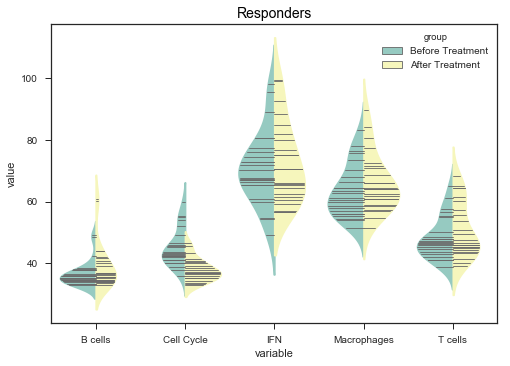

In [219]:
# Plotting Responders
g =sns.violinplot(x="variable", y="value", hue="group", split=True, inner = 'stick', data=exp_plot_melt_r, palette="Set3")
g.axes.set_title('Responders', fontsize=14, color="black")
plt.show()

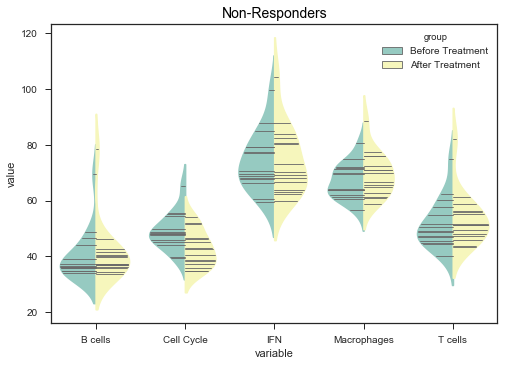

In [70]:
# Plotting Non-Responders
g =sns.violinplot(x="variable", y="value", hue="group", split=True, inner = 'stick', data=exp_plot_melt_nr, palette="Set3")
g.axes.set_title('Non-Responders', fontsize=14, color="black")
plt.show()

## Identifying the macrophage differentiation state
It is possible that the macrophages are in two different states of activation in responders and non-responders. The following ananlysis is to identify if such a state exits.